In [4]:
%load_ext autoreload
%autoreload 2

import bz2
import pickle
import shelve
import sys
from os import pipe
from pathlib import Path
from typing import Tuple

import numpy as np  # noqa: F401
import pandas as pd  # noqa: F401
import stanza
from stanza_batch import batch
from tqdm.notebook import tqdm 
import toma

from hnlp_proj.delta import DeltaTransformer, create_feature_matrix  # noqa: F401, F403
from hnlp_proj.loader import (
    BEN_YEHUDA_STANZA_PICKLE,  # noqa: F401, F403
    YNET_STANZA_PICKLE,
    load_ben_yehuda,
    load_debug,
    load_eng_test,
    load_ynet,
)
from hnlp_proj.processing import (
    Processing,  # noqa: F401, F403
    get_stanza_pipeline,
    process_data,
)
from hnlp_proj.utils import *  # noqa: F401, F403
from YAP_Wrapper.yap_wrapper.hebtokenizer import num

In [65]:
def load_dataset(ds_type: str) -> Tuple[pd.DataFrame, Path]:
    if ds_type == "ynet":
        return load_ynet(), YNET_STANZA_PICKLE
    if ds_type == "ben_yehuda":
        return load_ben_yehuda(), BEN_YEHUDA_STANZA_PICKLE
    raise ValueError(f"Invalid ds_type '{ds_type}'")


df, pickle_path = load_dataset("ben_yehuda")

if pickle_path.exists():
    raise ValueError(
        f"There is already a pickle file at {pickle_path}, please rename it to proceed"
    )
pickle_path.parent.mkdir(parents=True, exist_ok=True)

df.reset_index(inplace=True)

In [7]:
pipeline = get_stanza_pipeline(Processing.StanzaLemma, use_gpu=True)

def tomaFun(batch_size: int, nlp: stanza.Pipeline, data: pd.Series):
    print(f"Current batch size is {batch_size}")
    for doc in batch(data, nlp, batch_size=batch_size, clear_cache=True):
        yield doc


numDocs = 0
with shelve.open("benyehuda_stanza_docs-NEW.pickle") as docs:
    try:
        for doc in tqdm(toma.simple.batch(tomaFun, 32, pipeline, df["text"]), desc="Processing texts via stanza", total=len(df)):
            if numDocs % 100 == 0:
                print(f"Processed {numDocs + 1} documents out of {len(df)}")
            docs[str(numDocs)] = doc
            numDocs += 1
    except Exception as e:
        print(
            f"Got an exception after processing {len(docs)} out of {len(df)}: {e}",
            file=sys.stderr,
        )


Processing texts via stanza:   0%|          | 0/13408 [00:00<?, ?it/s]

Current batch size is 32
Processed 1 documents out of 13408
Processed 101 documents out of 13408
Processed 201 documents out of 13408
Processed 301 documents out of 13408
Processed 401 documents out of 13408
Processed 501 documents out of 13408
Processed 601 documents out of 13408
Processed 701 documents out of 13408
Processed 801 documents out of 13408
Processed 901 documents out of 13408
Processed 1001 documents out of 13408
Processed 1101 documents out of 13408
Processed 1201 documents out of 13408
Processed 1301 documents out of 13408
Processed 1401 documents out of 13408
Processed 1501 documents out of 13408
Processed 1601 documents out of 13408
Processed 1701 documents out of 13408
Processed 1801 documents out of 13408
Processed 1901 documents out of 13408
Processed 2001 documents out of 13408
Processed 2101 documents out of 13408
Processed 2201 documents out of 13408
Processed 2301 documents out of 13408
Processed 2401 documents out of 13408
Processed 2501 documents out of 13408

In [92]:

BEN_YEHUDA_FOLDER = Path("data") / "ben_yehuda"
BEN_YEHUDA_FOLDER.mkdir(exist_ok=True, parents=True)

shelf = shelve.open("benyehuda_stanza_docs.pickle")

grouped = df.sort_values(by="category").set_index(keys=["category"], drop=False)
groups = df["category"].unique()
groups_with_sizes = [(cat, df.loc[df.category == cat].shape[0]) for cat in groups]
for group, size in sorted(groups_with_sizes, key=lambda p: -p[1]):
	print(f"Loading stanza data for group {group} which has {size} elements")
	group_df = grouped.loc[group].copy()
# 	group_df["stanza_doc"] = list(tqdm(shelf[str(i)].to_dict() for i in range(group_df.shape[0])))
	print(f"\tPickling & Compressing dataframe for group {group}")
# 	group_df.to_pickle(str(BEN_YEHUDA_FOLDER / f"{group}.pickle.bz2"), protocol=5)

שירה 7022 shape (7022, 10)
מאמרים ומסות 3585 shape (7022, 10)
פרוזה 1780 shape (3585, 10)
עיון 370 shape (1780, 10)
זכרונות ויומנים 270 shape (370, 10)
מכתבים 201 shape (270, 10)
משלים 90 shape (201, 10)
מחזות 88 shape (90, 10)
מילונים ולקסיקונים 2 shape (88, 10)


(2555, 4467)

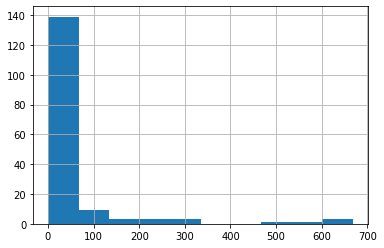

In [174]:
g2 = grouped.loc["שירה"]
g2 = g2.assign(authors=g2.authors.apply(" ".join)).set_index("authors", drop=False).sort_index()

grouped["authors"].apply(" ".join).value_counts().head(20)

ancient_poets = ["אברהם אבן עזרא", "שמואל הנגיד", "יהודה הלוי"]

# g2.loc[ancient_poets]

author_value_counts = g2["authors"].value_counts()
author_value_counts.hist()
big_authors = author_value_counts[author_value_counts > 200]
small_authors = author_value_counts[author_value_counts <= 200]

small_authors.sum(), big_authors.sum()

In [162]:
from pandas_profiling import ProfileReport

prof = ProfileReport(df, title="Prof")
prof

Render HTML: 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]
